# XGBoost model

In [708]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [709]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [710]:
df = pd.read_csv("dataset/enriched_train.csv")

In [711]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['D_Day_of_week'] = df['Date'].dt.dayofweek

In [712]:
df = df.drop(['NumberOfCustomers','Date'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [713]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [714]:
df.head().T

,0,1,2,3,4
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,0.000000
HasPromotions,1.000000,1.000000,1.000000,0.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,6.000000,6.000000,5.000000,7.000000,8.000000


In [715]:
df.shape

(523000, 48)

In [716]:
train = md.get_fake_train(df)

In [717]:
train.shape

(479184, 48)

In [718]:
test = md.get_fake_test(df)
test.shape

(43816, 48)

In [719]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [720]:
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
features.remove('Min_Dew_PointC')
features.remove('Max_Wind_SpeedKm_h')
features.remove('Max_VisibilityKm')
features.remove('IsOpen')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
print("features")

print(features)

features
['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'CloudCover', 'Max_Dew_PointC', 'Max_Humidity', 'Max_Sea_Level_PressurehPa', 'Max_TemperatureC', 'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h', 'Min_Humidity', 'Min_Sea_Level_PressurehPa', 'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm', 'WindDirDegrees', 'D_Day', 'D_DayOfYear', 'D_Month', 'D_Day_of_week', 'D_Year', 'MeanStoreSales', 'MeanRegionSales', 't-14', 't-7', 't-1', 't-2', 't-9', 't-8', 't-6', 't-15', 't-21', 't-13', 't-20']


In [721]:
features.remove('t-1')
features.remove('t-7')
features.remove('t-14')
features.remove('t-9')
features.remove('t-8')
features.remove('t-6')
features.remove('t-15')
features.remove('t-21')
features.remove('t-13')
features.remove('t-20')
features.remove('t-2')

In [722]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          #"gamma": 2  #added as a test
          }

#reg_alpha 
#reg_lambda
num_trees = 150 #400

In [723]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [724]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [725]:
X_train.shape

(455224, 48)

In [726]:
X_test.shape

(23960, 48)

In [727]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [728]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.34084	train-rmse:6.33994
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.07724	train-rmse:5.07636
[2]	test-rmse:4.0679	train-rmse:4.06712
[3]	test-rmse:3.25678	train-rmse:3.25651
[4]	test-rmse:2.61169	train-rmse:2.61173
[5]	test-rmse:2.09627	train-rmse:2.09651
[6]	test-rmse:1.68539	train-rmse:1.68609
[7]	test-rmse:1.35917	train-rmse:1.36016
[8]	test-rmse:1.09192	train-rmse:1.09353
[9]	test-rmse:0.879757	train-rmse:0.88206
[10]	test-rmse:0.715873	train-rmse:0.718679
[11]	test-rmse:0.587008	train-rmse:0.590369
[12]	test-rmse:0.480242	train-rmse:0.484315
[13]	test-rmse:0.396454	train-rmse:0.401478
[14]	test-rmse:0.336356	train-rmse:0.342129
[15]	test-rmse:0.285026	train-rmse:0.292021
[16]	test-rmse:0.250441	train-rmse:0.258268
[17]	test-rmse:0.224563	train-rmse:0.233164
[18]	test-rmse:0.206121	train-rmse:0.215319
[19]	test-rmse:0.18693	train-rmse:0.19709
[20]	te

### Validating

In [729]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.11889612488125514


RMSE

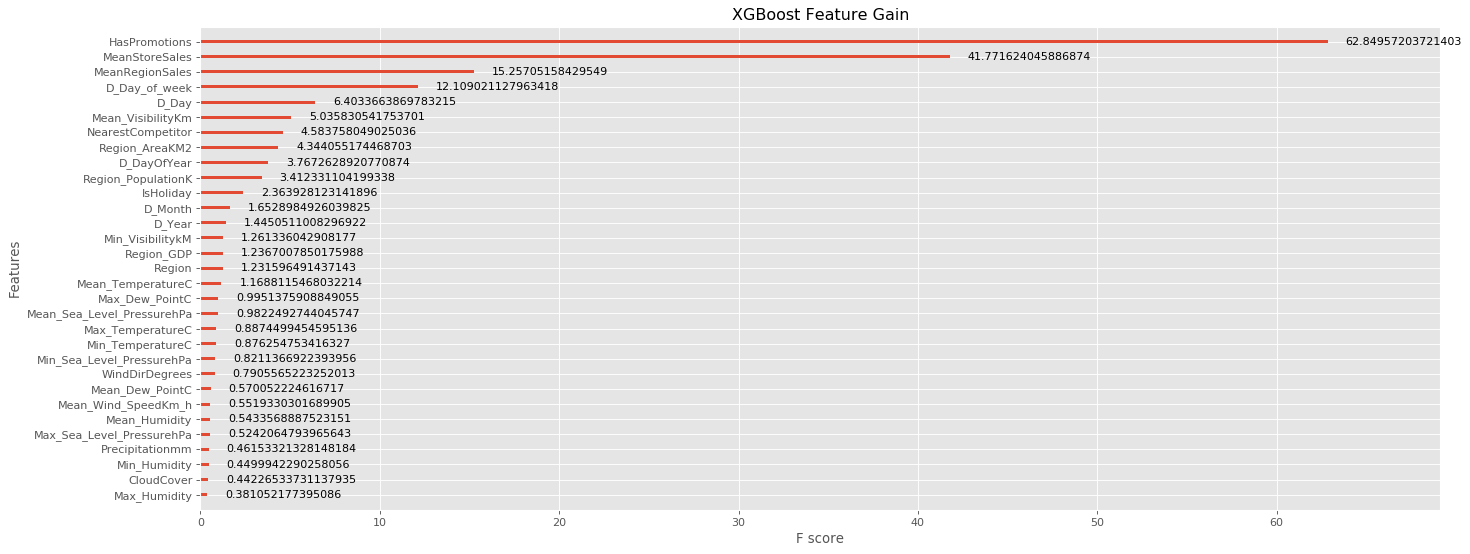

In [730]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

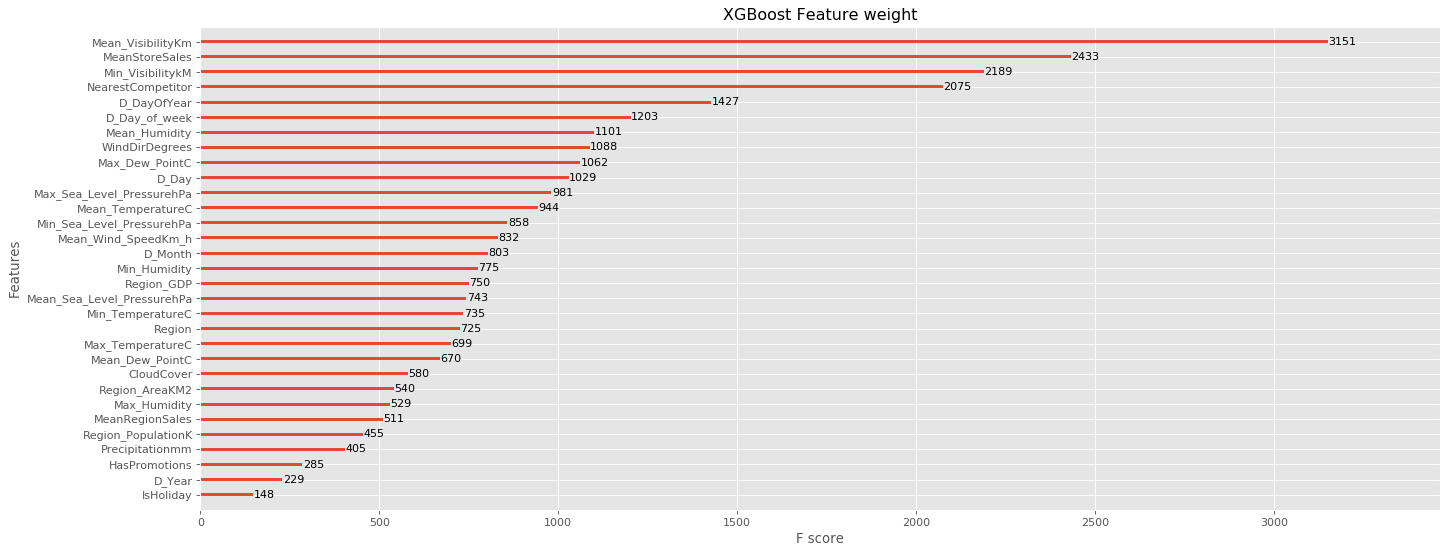

In [731]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

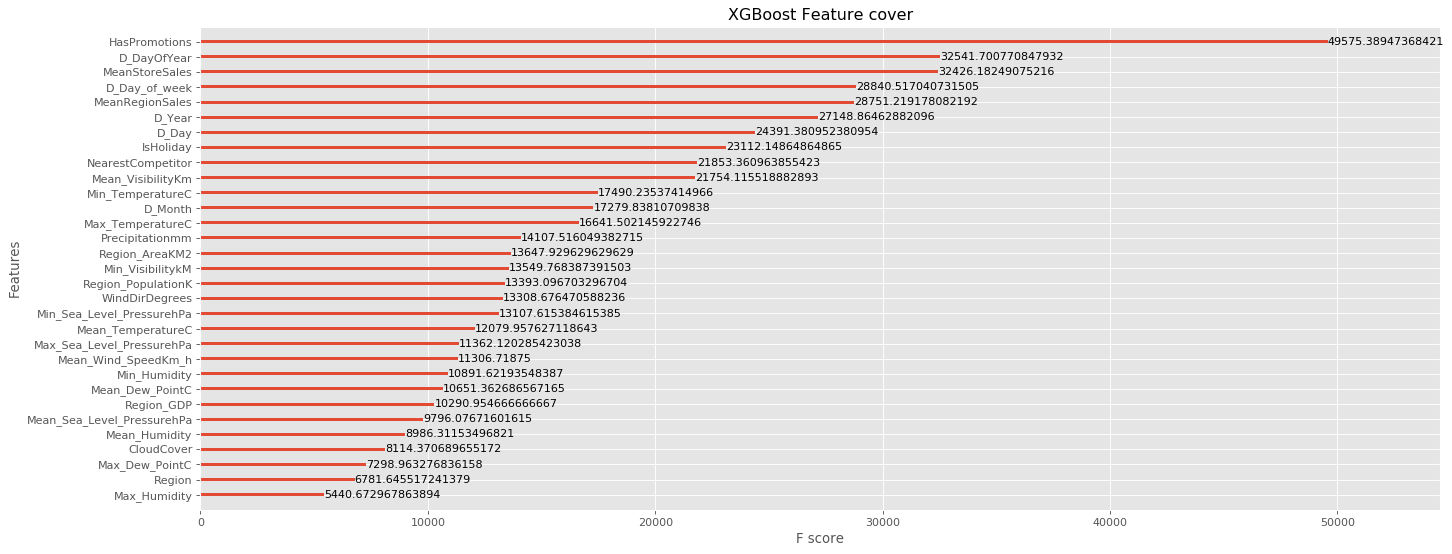

In [732]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [733]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [734]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [735]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.04981295374186408


In [192]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [193]:
diff.head(15).T

343   -1020.562500
344   -1001.001465
345     766.709473
346    1024.638672
347    -330.423629
348     563.083984
349     496.740234
350    -157.377930
351       9.276855
352    -438.596680
353    -846.928223
354    -334.380172
355   -1159.650391
356    -784.121582
357    -883.473633
dtype: float64

In [194]:
diff.mean()

105.68320384653046

In [195]:
train_probs.shape

(45689,)

In [196]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [197]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [198]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [199]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.1906332633043559


In [200]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
11847,3674.000000,2806.333984
11848,3758.073991,3694.969727
11849,3468.000000,3293.965820
11850,2836.000000,2913.733887
11851,2816.000000,3009.757080
11852,2919.000000,3098.549072
11853,4054.000000,3707.348145
11854,3793.000000,2729.045654
11855,3758.073991,3996.481689
11856,6245.000000,5123.181641


In [161]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
11847,3674.000000,2922.143555
11848,3758.073991,3691.728271
11849,3468.000000,3240.204102
11850,2836.000000,2986.788574
11851,2816.000000,3042.273438
11852,2919.000000,3069.326172
11853,4054.000000,3740.238281
11854,3793.000000,2866.475586
11855,3758.073991,3973.737549
11856,6245.000000,4872.062988


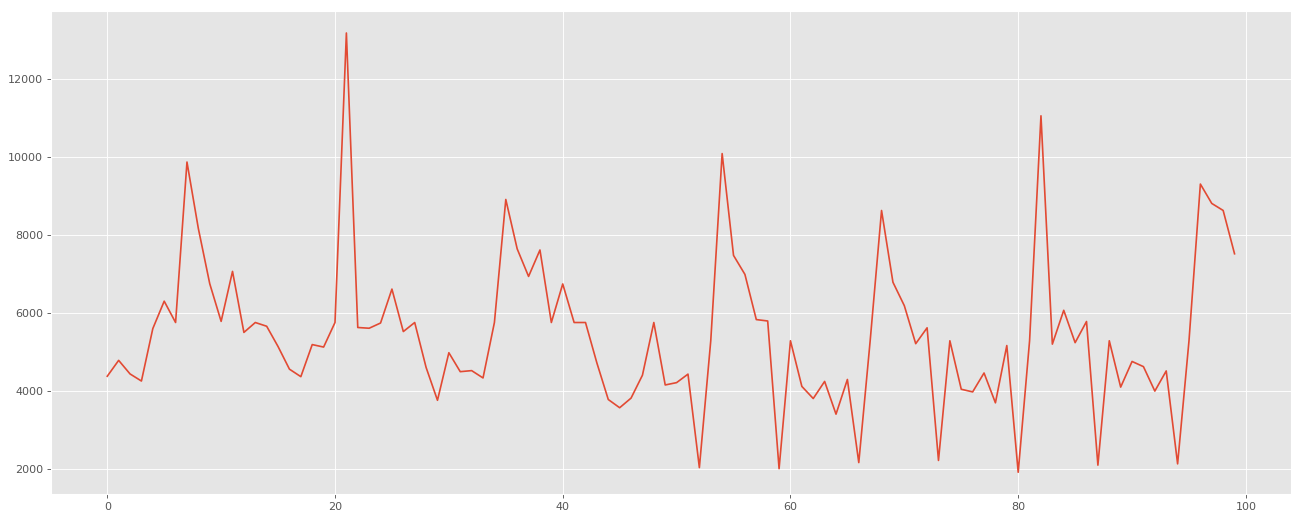

In [201]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

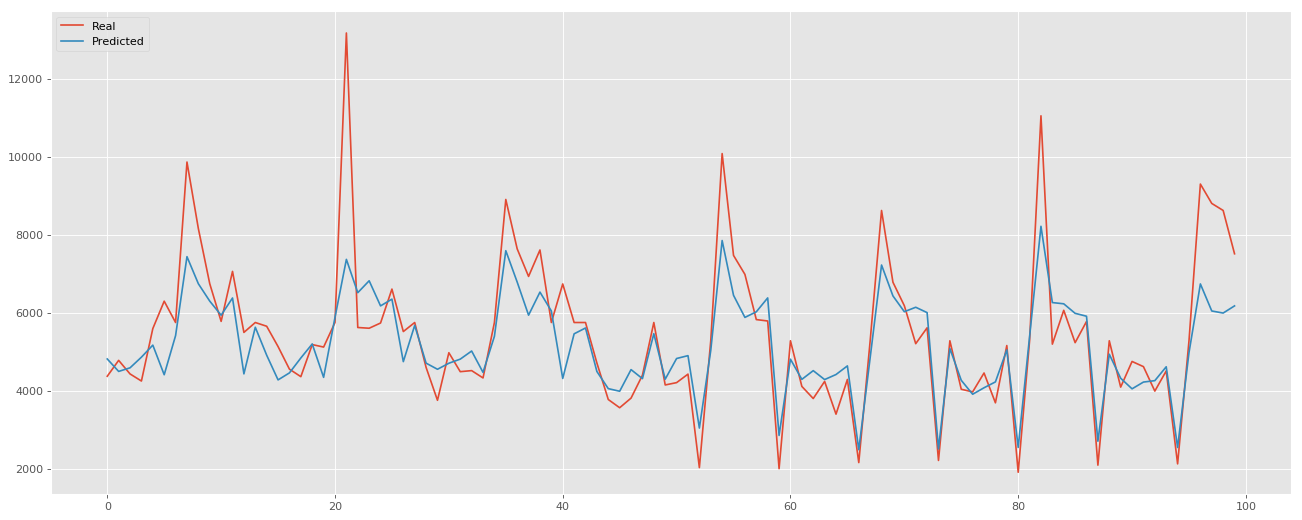

In [202]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [ ]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y